# Audio and spectrograms
This tutorial demonstrates how to use OpenSoundscape to open and modify audio files and spectrograms.

Audio files can be loaded into OpenSoundscape and modified using its `Audio` class. The class gives access to modifications such as trimming short clips from longer recordings, splitting a long clip into multiple segments, bandpassing recordings, and extending the length of recordings by looping them. Spectrograms can be created from `Audio` objects using the `Spectrogram` class. This class also allows useful features like measuring the amplitude signal of a recording, trimming a spectrogram in time and frequency, and converting the spectrogram to a saveable image.

To download the tutorial as a Jupyter Notebook, click the "Edit on GitHub" button at the top right of the tutorial. Using it requires that you install OpenSoundscape and follow the instructions for using it in Jupyter.

This tutorial uses an example audio file downloadable with the OpenSoundscape package. To use your own file for the following examples, replace the path in the line below with the absolute path to the file:

In [ ]:
audio_filename = '../../tests/audio/1min.wav'

## Quickstart

First, load the classes from OpenSoundscape.

In [2]:
# import Audio and Spectrogram classes from OpenSoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

The following code loads an audio file, creates a 224px x 224px -sized spectrogram from it, then creates and saves an image of the spectrogram to the desired path. Each step is discussed in depth below.

In [3]:
from pathlib import Path
# Settings
image_shape = (224,224)
image_path = Path('./saved_spectrogram.png')

# Open as Audio
audio = Audio.from_file(audio_filename)

# Convert into spectrogram
spectrogram = Spectrogram.from_audio(audio)

# Convert into image
image = spectrogram.to_image(shape=image_shape)

# Save image
image.save(image_path)

The above function calls can be condensed to a single line:

In [4]:
Spectrogram.from_audio(Audio.from_file(audio_filename)).to_image(shape=image_shape).save(image_path)

## Audio loading

Load audio files using OpenSoundscape's `Audio` class. 

OpenSoundscape uses a package called `librosa` to help load audio files. Librosa automatically supports `.wav` files, but to use `.mp3` files requires that librosa be installed with a package like `ffmpeg`. See [Librosa's installation tips](https://github.com/librosa/librosa#Hints-for-the-installation) for more information.

Load the example audio from file:

In [5]:
audio_object = Audio.from_file(audio_filename)

### Audio properties

The properties of an `Audio` object include its samples (the actual audio data) and the sample rate (the number of audio samples taken per second, required to understand the samples). After an audio file has been loaded, these can be accessed using the `samples` and `sample_rate` properties, respectively.

In [6]:
audio_object.samples

array([-0.00888062, -0.00344849,  0.00378418, ..., -0.00048828,
        0.00253296,  0.00109863], dtype=float32)

In [7]:
audio_object.sample_rate

32000

### Loading options

By default, an audio object is loaded with the same sample rate as the source recording. When loading from a file, the sampling rate can be changed or specified. This is useful when working with multiple files and ensuring that all files have a consistent sampling rate. Below, load the same audio file as above, but specify a sampling rate of 22050 Hz.

In [8]:
audio_object_resample = Audio.from_file(audio_filename, sample_rate=22050)
audio_object_resample.sample_rate

22050

For other options when loading audio objects, see the [`from_file()` documentation](api.html#opensoundscape.audio.Audio.from_file).

## Audio methods

The `Audio` class gives access to a variety of tools to change audio files, load them with special properties, or get information about them. The below examples demonstrate how to bandpass audio recordings, get their duration, extending their length, and trim them. These modifications do not change the original object or the original file itself; instead, they save or return new objects.

Another helpful tool enables the user to trim a series of consecutive clips from a longer audio file. This can be used to split up long files to ready them as inputs to machine learning algorithms. For an example of this, see the [data preparation section of the prediction tutorial](predict.html#Prepare-prediction-files). For a description of the entire `Audio` object API, see the [API documentation](api.html#module-opensoundscape.audio).

### Bandpassing
Bandpass the audio file to limit its frequency range to 1000 Hz to 5000 Hz. 

In [9]:
bandpassed = audio_object.bandpass(low_f = 1000, high_f = 5000, order=9)

### Duration
Get the current duration of the audio in `audio_object`.

In [10]:
length = audio_object.duration()
print(length)

60.0


### Extending
Using the duration gotten above, extend the recording to twice its original duration. Internally, this function loops the recording until it reaches the desired length.

In [11]:
extended = audio_object.extend(length * 2)
print(extended.duration())

120.0


### Trimming
Trim the extended recording to its original length again, but select the last 60 seconds instead of the first 60 seconds.

In [12]:
trimmed = extended.trim(start_time = 60.0, end_time = 120.0)

The below logic shows that the samples of the original audio object are equal to the samples of the extended-then-trimmed audio object.

In [13]:
from numpy.testing import assert_array_equal
assert_array_equal(trimmed.samples, audio_object.samples)

## Spectrogram creation

### Loading spectrograms
A `Spectrogram` object can be created from an audio object using the `from_audio()` method.

In [14]:
audio_object = Audio.from_file(audio_filename)
spectrogram_object = Spectrogram.from_audio(audio_object)

Spectrograms can also be loaded from saved images using the `from_file()` method.

### Spectrogram properties

To check the scale of a spectrogram, you can look at its `times` and `frequencies` properties. The `times` property is the list of times represented by each column of the spectrogram. The `frequencies` property is the list of frequencies represented by each row of the spectrogram. These are not the actual values of the spectrogram -- just the scale of the spectrogram itself.

In [15]:
spec = Spectrogram.from_audio(Audio.from_file(audio_filename))
print(f'the first few times: {spec.times[0:5]}')
print(f'the first few frequencies: {spec.frequencies[0:5]}')

the first few times: [0.008 0.016 0.024 0.032 0.04 ]
the first few frequencies: [  0.   62.5 125.  187.5 250. ]


### Loading options

Loading a spectrogram from an `Audio` object gives access to several options to customize the calculation of the spectrogram. For instance, use the following steps to create a spectrogram with a higher time-resolution. 

First, load an audio file with high sample rate.

In [16]:
audio = Audio.from_file(audio_filename, sample_rate=44100)

Next, create a spectrogram with 100-sample windows (100/44100 s of audio per window) and no overlap.

In [17]:
spec = Spectrogram.from_audio(audio, window_samples=100, overlap_samples=0)

Note that while this increases the time-resolution of a spectrogram, it reduces the frequency-resolution of the spectrogram.

For other options when loading spectrogram objects from audio objects, see the [`from_audio()` documentation](api.html#opensoundscape.spectrogram.Spectrogram.from_audio).

## Spectrogram methods

The tools and features of the spectrogram class are demonstrated here, including plotting; how spectrograms can be generated from modified audio; saving a spectrogram as an image; customizing a spectrogram; trimming and bandpassing a spectrogram; and calculating the amplitude signal from a spectrogram.

### Plotting
A `Spectrogram` object can be plotted using its `plot()` method.

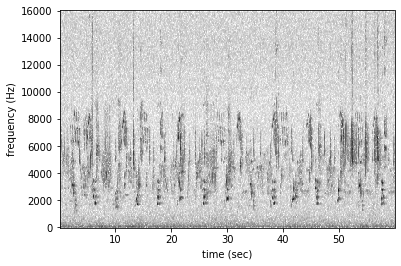

In [18]:
audio_object = Audio.from_file(audio_filename)
spectrogram_object = Spectrogram.from_audio(audio_object)
spectrogram_object.plot()

### Loading modified audio

The `from_audio` method converts whatever audio is inside the audio object into a spectrogram. So, modified `Audio` objects can be turned into spectrograms as well. 

For example, the code below demonstrates creating a spectrogram from a 5 second long trim of the audio object. Compare this plot to the plot above.

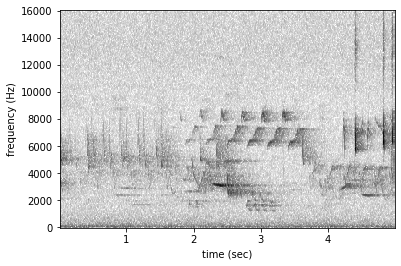

In [19]:
# Trim the original audio
trimmed = audio_object.trim(0, 5)

# Create a spectrogram from the trimmed audio
spec = Spectrogram.from_audio(trimmed)

# Plot the spectrogram
spec.plot()

### Saving a spectrogram

To save the created spectrogram, first convert it to an image. It will no longer be an OpenSoundscape `Spectrogram` object, but instead a Python Image Library (PIL) `Image` object.

In [20]:
print("Type of `spectrogram_audio`, before conversion:", type(spectrogram_object))
spectrogram_image = spectrogram_object.to_image()
print("Type of `spectrogram_image`, after conversion:", type(spectrogram_image))

Type of `spectrogram_audio`, before conversion: <class 'opensoundscape.spectrogram.Spectrogram'>
Type of `spectrogram_image`, after conversion: <class 'PIL.Image.Image'>


Save the PIL Image using its `save()` method, supplying the filename at which you want to save the image.

In [21]:
image_path = Path('./saved_spectrogram.png')
spectrogram_image.save(image_path)

To save the spectrogram at a desired size, specify the image shape when converting the `Spectrogram` to a PIL `Image`.

In [22]:
image_shape = (512,512)
large_image_path = Path('./saved_spectrogram_large.png')
spectrogram_image = spectrogram_object.to_image(shape=image_shape)
spectrogram_image.save(large_image_path)

### Trimming

Spectrograms can be trimmed in time using `trim()`. Trim the above spectrogram to zoom in on one vocalization.

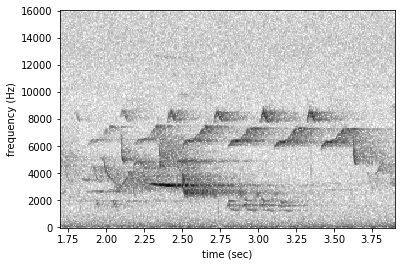

In [23]:
spec_trimmed = spec.trim(1.7, 3.9)
spec_trimmed.plot()

### Bandpassing
Spectrograms can be trimmed in frequency using `bandpass()`. For instance, the vocalization zoomed in on above is the song of a Black-and-white Warbler (*Mniotilta varia*), one of the highest-frequency bird songs in our area. Set its approximate frequency range.

In [24]:
baww_low_freq = 5500
baww_high_freq = 9500

Bandpass the above time-trimmed spectrogram in frequency as well to limit the spectrogram view to the vocalization of interest.

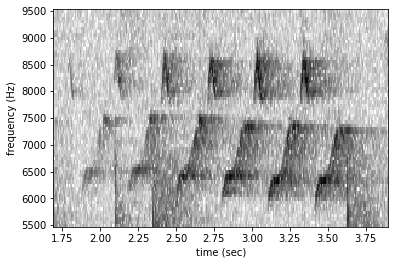

In [25]:
spec_bandpassed = spec_trimmed.bandpass(baww_low_freq, baww_high_freq)
spec_bandpassed.plot()

### Calculating amplitude signal

OpenSoundscape can calculate the amplitude of an audio file over time using the `Spectrogram` class. First, make a spectrogram from 5 seconds' worth of audio.

In [26]:
spec = Spectrogram.from_audio(Audio.from_file(audio_filename).trim(0,5))

Next, use the `amplitude()` method to get the amplitude signal.

In [27]:
high_freq_amplitude = spec.amplitude()

Plot this signal over time to visualize it.

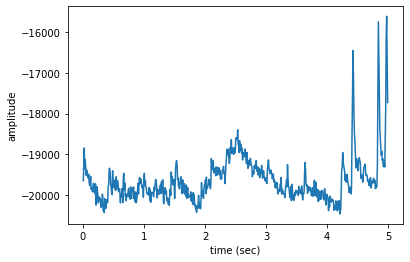

In [28]:
from matplotlib import pyplot as plt
plt.plot(spec.times,high_freq_amplitude)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

It is also possible to get the amplitude signal from a restricted range of frequencies, e.g., to look at the amplitude in the frequency range of a species of interest.

Look again at the frequency range of the Black-and-white Warbler, discussed above.

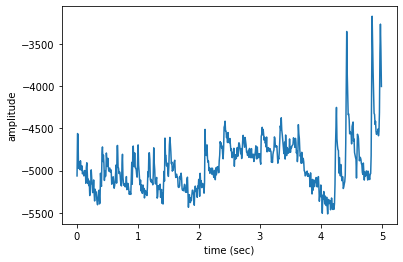

In [29]:
# Get amplitude signal
high_freq_amplitude = spec.amplitude(freq_range=[baww_low_freq, baww_high_freq])

# Plot signal
plt.plot(spec.times, high_freq_amplitude)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

The amplitude in the Black-and-white Warbler frequency range is on average lower in the first two seconds of the recording, gets higher when the warbler sings between 2-4s, and then drops off at 4s. At 4-5s into the recording, there are large spikes in this frequency range from high-frequency noise, the loud "chips" of another animal. 

Amplitude signals like these can be used to identify periodic calls, like those by many species of frogs. A pulsing-call identification pipeline called [RIBBIT](RIBBIT_pulse_rate_demo.html) is implemented in OpenSoundscape.

Amplitude signals may not be the most reliable method of identification for species like birds. In this case, it is possible to create a machine learning algorithm to identify calls based on their appearance on spectrograms. For more information, see the [algorithm training](train.html) tutorial. The developers of OpenSoundscape have trained machine learning models for over 500 common North American bird species; for examples of how to download demonstration models, see the [prediction](predict.html) tutorial.

#### Clean up
Clean up the files created during this demo.

In [30]:
image_path.unlink()
large_image_path.unlink()